Filas antes de limpiar NaN: 17520
Filas después de limpiar NaN: 17352

Estadísticas de features engineered:


,lag_1h,lag_24h,rolling_mean_24h,rolling_std_24h,temp_squared,demand_efficiency_interaction
count,17352.000000,17352.000000,17352.000000,17352.000000,17352.000000,17352.000000
mean,1456.915273,1456.571243,1456.766586,48.258634,549.716305,0.549973
std,111.545998,111.527340,100.479048,10.522952,512.880532,0.233204
min,973.890000,973.890000,1204.278750,17.600917,0.000000,0.000000
25%,1379.482500,1379.100000,1383.391354,40.628762,108.576400,0.374628
50%,1459.430000,1459.000000,1457.753125,47.019077,401.200900,0.548318
75%,1537.987500,1537.515000,1532.402083,55.031074,871.430400,0.735017
max,1758.400000,1758.400000,1693.972917,99.766606,2290.579600,1.000000


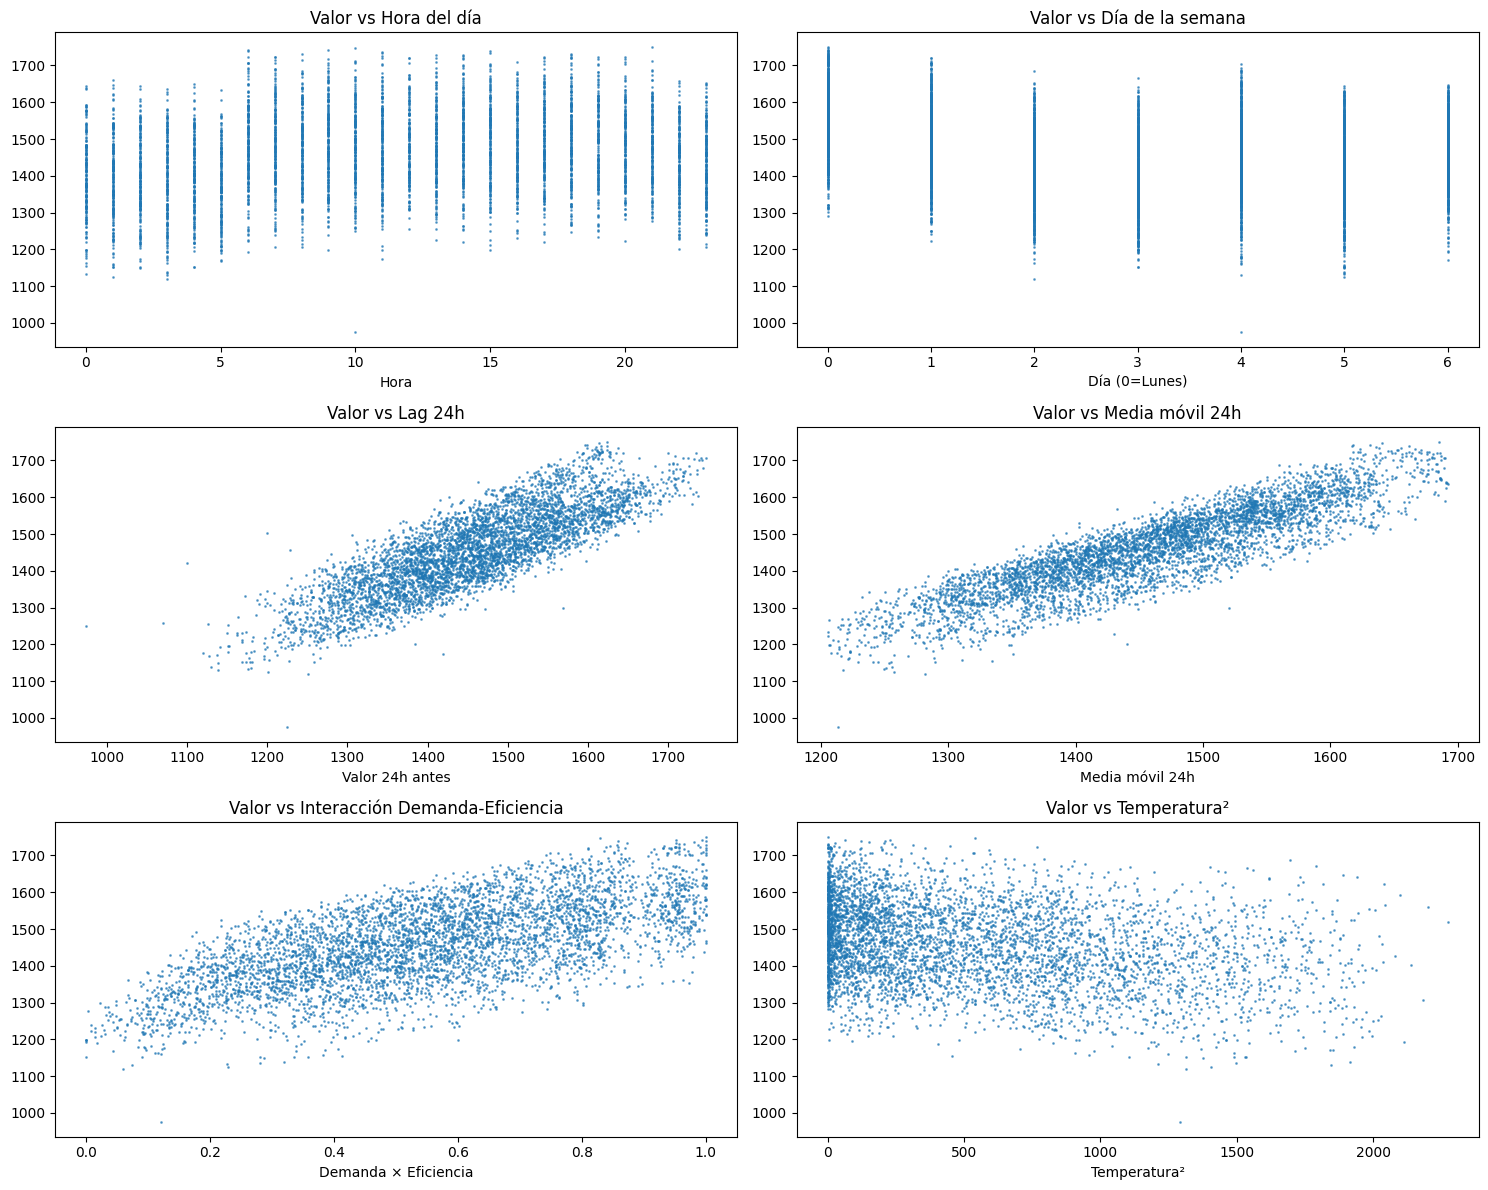


✅ Dataset con features guardado en: ../data/processed/industrial_timeseries_featured.csv
Features totales: 21
Registros: 17,352


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar datos
df = pd.read_csv("../data/raw/industrial_timeseries.csv", parse_dates=["timestamp"])

# Crear features temporales adicionales
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
df["quarter"] = df["timestamp"].dt.quarter

# Features de lag (valores pasados)
df["lag_1h"] = df["value"].shift(1)
df["lag_24h"] = df["value"].shift(24)
df["lag_168h"] = df["value"].shift(168)  # 1 semana

# Features de rolling statistics
df["rolling_mean_24h"] = df["value"].rolling(window=24).mean()
df["rolling_std_24h"] = df["value"].rolling(window=24).std()
df["rolling_mean_168h"] = df["value"].rolling(window=168).mean()  # media semanal

# Features de temperatura
df["temp_squared"] = df["temperature"] ** 2
df["temp_lag_1h"] = df["temperature"].shift(1)

# Features de interacción
df["demand_efficiency_interaction"] = df["demand_factor"] * df["operational_efficiency"]
df["temp_demand_interaction"] = df["temperature"] * df["demand_factor"]

# Drop filas con NaN (causadas por lag y rolling)
print(f"Filas antes de limpiar NaN: {len(df)}")
df = df.dropna().reset_index(drop=True)
print(f"Filas después de limpiar NaN: {len(df)}")

# Estadísticas de las nuevas features
print("\nEstadísticas de features engineered:")
engineered_features = ['lag_1h', 'lag_24h', 'rolling_mean_24h', 'rolling_std_24h', 
                      'temp_squared', 'demand_efficiency_interaction']
display(df[engineered_features].describe())

# Visualizaciones de las nuevas features vs valor objetivo
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Muestrear datos para visualización más clara
sample_df = df.sample(n=min(5000, len(df)), random_state=42)

axes[0].scatter(sample_df["hour"], sample_df["value"], alpha=0.6, s=1)
axes[0].set_title("Valor vs Hora del día")
axes[0].set_xlabel("Hora")

axes[1].scatter(sample_df["day_of_week"], sample_df["value"], alpha=0.6, s=1)
axes[1].set_title("Valor vs Día de la semana")
axes[1].set_xlabel("Día (0=Lunes)")

axes[2].scatter(sample_df["lag_24h"], sample_df["value"], alpha=0.6, s=1)
axes[2].set_title("Valor vs Lag 24h")
axes[2].set_xlabel("Valor 24h antes")

axes[3].scatter(sample_df["rolling_mean_24h"], sample_df["value"], alpha=0.6, s=1)
axes[3].set_title("Valor vs Media móvil 24h")
axes[3].set_xlabel("Media móvil 24h")

axes[4].scatter(sample_df["demand_efficiency_interaction"], sample_df["value"], alpha=0.6, s=1)
axes[4].set_title("Valor vs Interacción Demanda-Eficiencia")
axes[4].set_xlabel("Demanda × Eficiencia")

axes[5].scatter(sample_df["temp_squared"], sample_df["value"], alpha=0.6, s=1)
axes[5].set_title("Valor vs Temperatura²")
axes[5].set_xlabel("Temperatura²")

plt.tight_layout()
plt.show()

# Guardar dataset con features engineered para uso en notebooks posteriores
df.to_csv("../data/processed/industrial_timeseries_featured.csv", index=False)
print(f"\n✅ Dataset con features guardado en: ../data/processed/industrial_timeseries_featured.csv")
print(f"Features totales: {len(df.columns)}")
print(f"Registros: {len(df):,}")